In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prophet import Prophet

import plotly.express as px


c:\Users\Prime\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_data(path):
    df = pd.read_csv(path)
    df.head()
    return df

In [5]:
def clean_data(df):
    # Check for missing values
    df.isnull().sum()
    # Handle missing values (e.g., drop rows with missing values)
    df.dropna(inplace=True)
    # Remove duplicate rows
    df.drop_duplicates(inplace=True)

    df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%y')
    df.rename(columns={'APPNAME': 'Application', 'API': 'API_Version', 'STATUS': 'Status', 'COUNT': 'Request_Count'}, inplace=True) 

    return df


In [6]:
def Data_by_API(df):
    # Group data by API
    df_by_api = df.groupby(['DATE', 'API_Version', 'Status']).sum().reset_index()
    df_by_api = df_by_api.sort_values(by=['Request_Count'], ascending=False)
    df_by_api.drop(columns=['Application'], inplace=True)
    df_by_api.sort_values(by=['DATE'], inplace=True)
    return df_by_api

In [7]:
def Data_by_APP(df):
    # Group data by APP
    df_by_app = df.groupby(['DATE', 'Application', 'Status']).sum().reset_index()
    df_by_app = df_by_app.sort_values(by=['Request_Count'], ascending=False)
    df_by_app.drop(columns=['API_Version'], inplace=True)
    df_by_app.sort_values(by=['DATE'], inplace=True)
    return df_by_app

In [8]:
def Data_by_DATE(df):
    # Group data by DATE
    df_by_date = df.groupby(['DATE', 'Status']).sum().reset_index()
    df_by_date.drop(columns=['API_Version', 'Application'], inplace=True)
    df_by_date.sort_values(by=['DATE'], inplace=True)
    return df_by_date

# Data Visualization

In [9]:
def histogram(df):
    df['Request_Count'].hist()
    plt.title('Distribution of Request Counts')
    plt.xlabel('Request Count')
    plt.ylabel('Frequency')
    plt.show()

In [10]:
def box(df, text = 'DATE'):
    df.boxplot(column='Request_Count', by= text, figsize=(17, 9))
    plt.title('Box Plot of Request Counts')
    plt.ylabel('Request Count')
    plt.show()


In [11]:
def time_series(df):
    time_series_df = df.groupby('DATE')['Request_Count'].sum()
    time_series_df.plot(figsize=(17, 6))
    plt.title('Time Series of Request Counts')
    plt.xlabel('Date')
    plt.ylabel('Request Count')
    plt.show()


In [12]:
def bar(df):
    application_counts = df['Application'].value_counts()
    application_counts.plot(kind='bar')
    plt.title('Request Counts by Application')
    plt.xlabel('Application')
    plt.ylabel('Request Count')
    plt.show()


In [13]:
def correlation(df):
    le = LabelEncoder()
    df['Application'] = le.fit_transform(df['Application'])
    df['API_Version'] = le.fit_transform(df['API_Version'])
    df['Status'] = le.fit_transform(df['Status'])
    correlation_matrix = df.corr()
    # Visualize the correlation matrix as a heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


In [14]:
def display_table(df):
    print(df.describe())
    print(df.info())
    print(df.dtypes)
    print(df)

# Main Program

In [15]:
data = load_data('API_Trend.csv')
#display_table(data)
c_data = clean_data(data)
#display_table(c_data)
c_data.sort_values(by=['DATE'], inplace=True)
#display_table(c_data)

                                DATE  Request_Count
count                           3493   3.493000e+03
mean   2023-08-11 02:40:21.986830848   2.153965e+06
min              2023-07-04 00:00:00   1.000000e+00
25%              2023-07-23 00:00:00   7.030000e+02
50%              2023-08-11 00:00:00   2.517680e+05
75%              2023-08-31 00:00:00   1.057832e+06
max              2023-09-19 00:00:00   3.261928e+07
std                              NaN   5.488904e+06
<class 'pandas.core.frame.DataFrame'>
Index: 3493 entries, 35 to 3458
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           3493 non-null   datetime64[ns]
 1   API_Version    3493 non-null   object        
 2   Status         3493 non-null   object        
 3   Request_Count  3493 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 136.4+ KB
None
DATE             datetime64[ns]
API_Version     

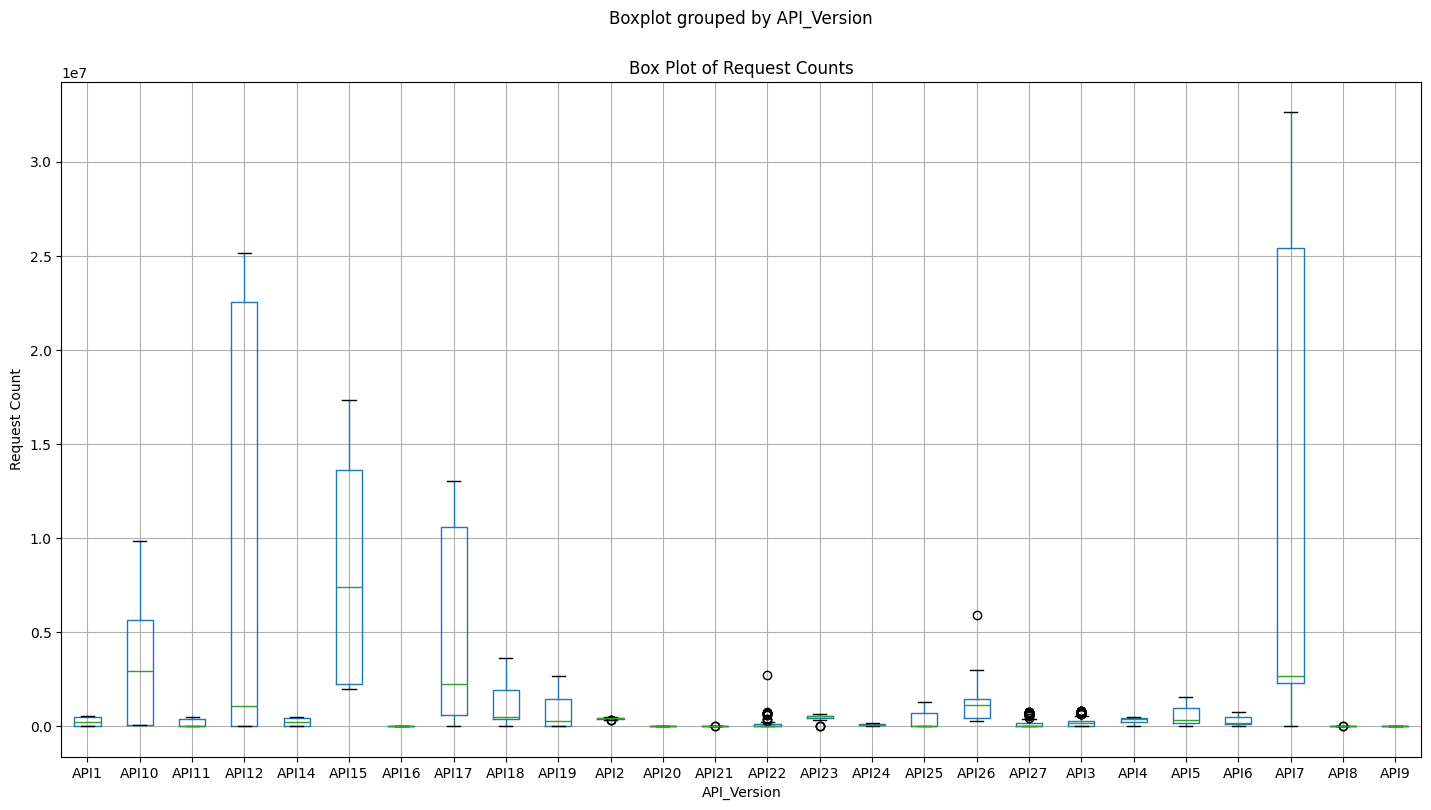

In [16]:
#Group data by API
API_data = Data_by_API(c_data)
display_table(API_data)
box(API_data, 'API_Version')

In [17]:
#Group data by APP
APP_data = Data_by_APP(c_data)
display_table(APP_data)

                                DATE  Request_Count
count                          15284   1.528400e+04
mean   2023-08-11 10:27:23.130070784   4.922664e+05
min              2023-07-04 00:00:00   1.000000e+00
25%              2023-07-23 00:00:00   6.100000e+01
50%              2023-08-11 00:00:00   2.322000e+03
75%              2023-08-31 00:00:00   5.823350e+04
max              2023-09-19 00:00:00   1.894917e+07
std                              NaN   1.904874e+06
<class 'pandas.core.frame.DataFrame'>
Index: 15284 entries, 116 to 15239
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           15284 non-null  datetime64[ns]
 1   Application    15284 non-null  object        
 2   Status         15284 non-null  object        
 3   Request_Count  15284 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 597.0+ KB
None
DATE             datetime64[ns]
Application  

                      DATE  Request_Count
count                  234   2.340000e+02
mean   2023-08-11 12:00:00   3.215299e+07
min    2023-07-04 00:00:00   2.000000e+00
25%    2023-07-23 00:00:00   1.250000e+01
50%    2023-08-11 12:00:00   1.336727e+07
75%    2023-08-31 00:00:00   7.967682e+07
max    2023-09-19 00:00:00   9.910669e+07
std                    NaN   3.640629e+07
<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 0 to 233
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           234 non-null    datetime64[ns]
 1   Status         234 non-null    object        
 2   Request_Count  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.3+ KB
None
DATE             datetime64[ns]
Status                   object
Request_Count             int64
dtype: object
          DATE Status  Request_Count
0   2023-07-04      F       13616467
1   2023-0

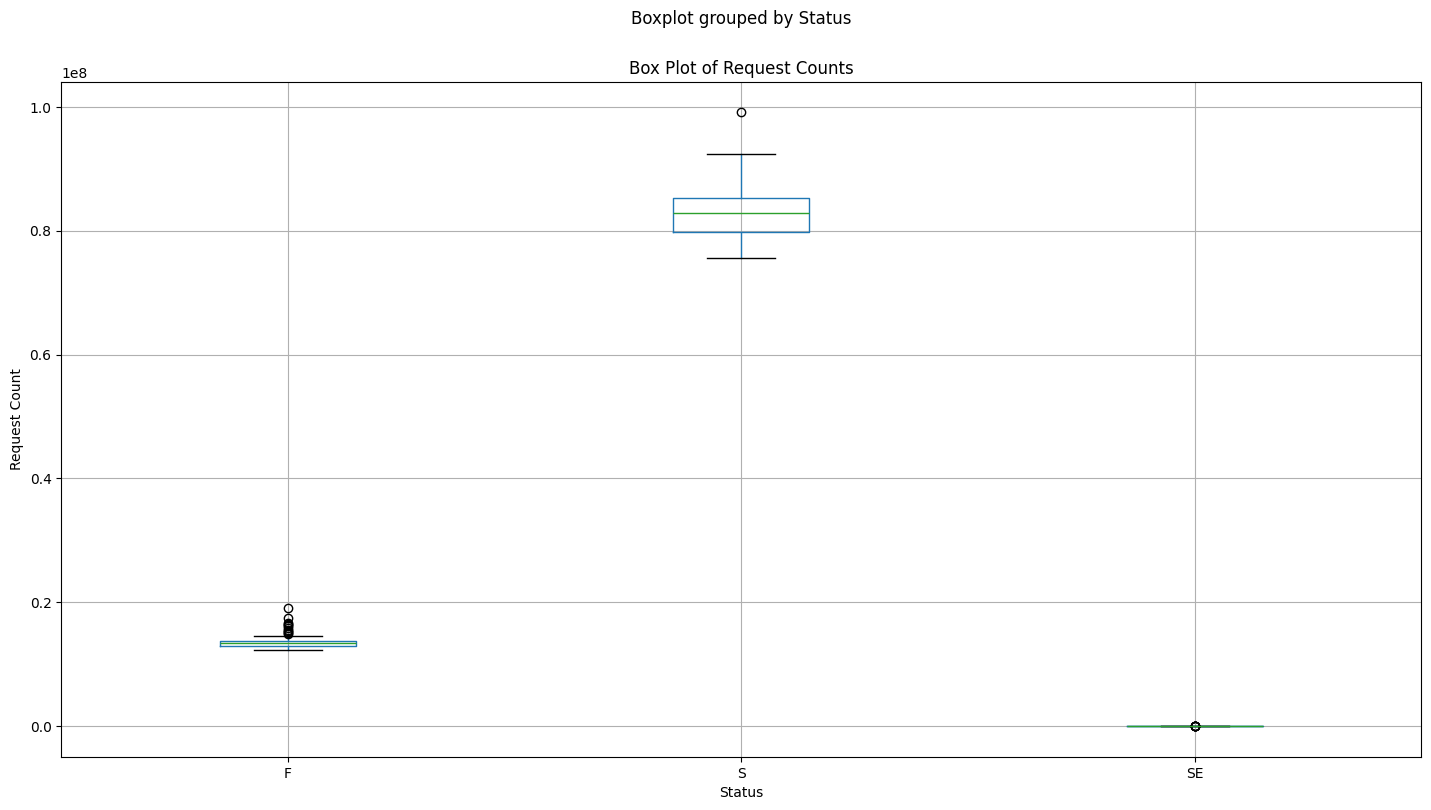

In [18]:
#Group data by DATE
DATE_data = Data_by_DATE(c_data)
display_table(DATE_data)
box(DATE_data, 'Status')

In [19]:
def time_series_data(df):
    total_unpro_df = c_data[c_data['Status'] != 'SE']
    data__total = total_unpro_df.groupby(['DATE']).sum().reset_index()
    data__total.drop(columns=['API_Version', 'Application', 'Status'], inplace=True)
    data__total.rename(columns={ 'DATE':'ds','Request_Count': 'y'}, inplace=True) 
    
    return data__total

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from datetime import datetime, timedelta
import collections
collections.Callable = collections.abc.Callable


In [69]:
data_total = time_series_data(c_data)

data_total['dow'] = data_total['ds'].dt.dayofweek.astype(int)
data_total['ds'] = data_total['ds'].values.astype(float)

isolation_forest = IsolationForest(contamination=0.1)  # You can adjust the contamination parameter

y_pred = isolation_forest.fit_predict(data_total)
data_total_no_outliers = data_total[y_pred == 1]

In [71]:
X = data_total_no_outliers[['ds', 'dow']]
y = data_total_no_outliers['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Assuming you've already converted 'ds' to float earlier
# Revert 'ds' back to datetime64[ns]
data_total['ds'] = data_total['ds'].astype('datetime64[ns]')
last_date = data_total['ds'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7, freq='D')
future_dates_df = pd.DataFrame({'ds': future_dates})
future_dates_df['dow'] = future_dates_df['ds'].dt.dayofweek.astype(int)
future_dates_df['ds'] = future_dates_df['ds'].values.astype(float)
future_predictions = model.predict(future_dates_df)

future_predictions

array([97118536.99, 97578374.34, 97679222.07, 97453127.51, 96775113.62,
       94075154.62, 97023092.01])

In [73]:
# Create a figure
fig = px.line()

# Add traces to the figure
#fig.add_trace(px.line(x=data_total['ds'], y=data_total['y']).data[0])
fig.add_trace(px.line(x=future_dates, y=future_predictions).data[0])

# Show the figure
fig.show()

c:\Users\Prime\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

